# links

1. [How to Prepare Univariate Time Series Data for Long Short-Term Memory Networks](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/)
2. [https://github.com/MohammadFneish7/Keras_LSTM_Diagram](Keras_LSTM_Diagram)
3. [How to Develop LSTM Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

In [0]:
# %tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0-rc1


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    # we have a dataset of shape(batch_size, timesteps)
    # rnn takes a 3-d input of shape(batch_size, timesteps, dimenstionality)
    # so as to increase the dimension we can use a lambda layer which is a part of the
    # network to do so, lambda layers gives us greater control over the network
    # link - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda?version=stable
    
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 408ms/step - loss: 195.6116 - mae: 196.0721
Epoch 2/100
8/8 [==============================] - 0s 59ms/step - loss: 194.9003 - mae: 195.2835
Epoch 3/100
8/8 [==============================] - 0s 55ms/step - loss: 193.7610 - mae: 194.0106
Epoch 4/100
8/8 [==============================] - 1s 65ms/step - loss: 191.7774 - mae: 192.4088
Epoch 5/100
8/8 [==============================] - 0s 57ms/step - loss: 189.9134 - mae: 190.5220
Epoch 6/100
8/8 [==============================] - 0s 52ms/step - loss: 188.0890 - mae: 188.3527
Epoch 7/100
8/8 [==============================] - 0s 53ms/step - loss: 185.2864 - mae: 185.8775
Epoch 8/100
8/8 [==============================] - 1s 65ms/step - loss: 182.3494 - mae: 183.0459
Epoch 9/100
8/8 [==============================] - 0s 59ms/step - loss: 179.0416 - mae: 179.8092
Epoch 10/100
8/8 [==============================] - 0s 52ms/step - loss: 175.7152 - mae: 176.0968
Epoch 11/100
8/8 [==========

[1e-08, 0.0001, 0, 30]

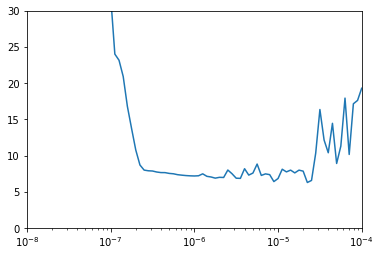

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 234ms/step - loss: 81.1158 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 0s 62ms/step - loss: 23.6081 - mae: 24.3852
Epoch 3/400
8/8 [==============================] - 0s 54ms/step - loss: 18.2197 - mae: 18.7073
Epoch 4/400
8/8 [==============================] - 0s 61ms/step - loss: 14.1504 - mae: 14.6783
Epoch 5/400
8/8 [==============================] - 0s 58ms/step - loss: 10.7208 - mae: 11.2663
Epoch 6/400
8/8 [==============================] - 0s 61ms/step - loss: 12.5591 - mae: 12.6964
Epoch 7/400
8/8 [==============================] - 0s 55ms/step - loss: 12.1410 - mae: 12.6867
Epoch 8/400
8/8 [==============================] - 0s 59ms/step - loss: 10.3559 - mae: 10.8805
Epoch 9/400
8/8 [==============================] - 0s 62ms/step - loss: 9.4729 - mae: 9.9451
Epoch 10/400
8/8 [==============================] - 0s 49ms/step - loss: 11.2710 - mae: 11.8202
Epoch 11/400
8/8 [==============================] 

In [0]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

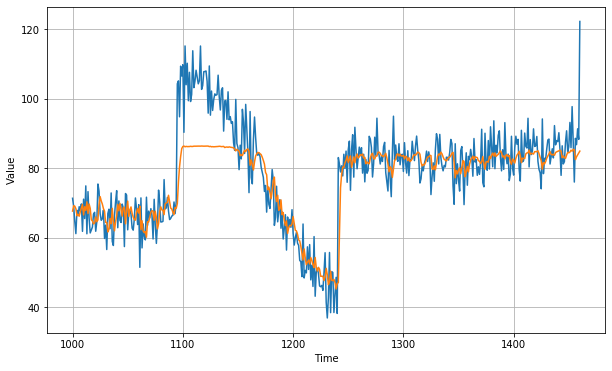

In [0]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.959153

<Figure size 432x288 with 0 Axes>

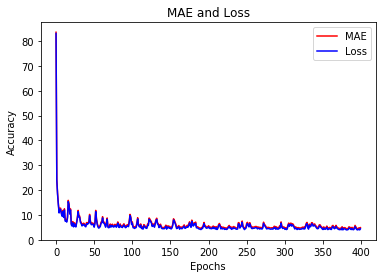

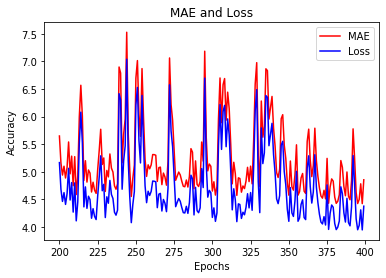

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()